In [1]:
from SimPEG import Mesh, Maps, Utils
import numpy as np
from matplotlib.colors import LogNorm
from simpegem1d import (
    GlobalEM1DProblemFD, GlobalEM1DSurveyFD, get_vertical_discretization_frequency
)
from pymatsolver import PardisoSolver
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import SimPEG

In [3]:
import h5py
import tarfile
import os
import shutil
def download_and_unzip_data(
    url = "https://storage.googleapis.com/simpeg/bookpurnong/bookpurnong_inversion.tar.gz"
):
    """
    Download the data from the storage bucket, unzip the tar file, return
    the directory where the data are
    """
    # download the data
    downloads = Utils.download(url)

    # directory where the downloaded files are
    directory = downloads.split(".")[0]

    # unzip the tarfile
    tar = tarfile.open(downloads, "r")
    tar.extractall()
    tar.close()

    return downloads, directory

/Users/sgkang/anaconda2/envs/simpeg/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# download the data
downloads, directory = download_and_unzip_data()

# Load resolve data
resolve = h5py.File(
    os.path.sep.join([directory, "booky_resolve.hdf5"]),
    "r"
)

river_path = resolve["river_path"].value    # River path
nskip = 1
nSounding = resolve["data"][::nskip, :].shape[0]    # the # of soundings

# Bird height from surface
b_height_resolve = (resolve["src_elevation"])[::nskip]

# fetch the frequencies we are considering
cpi_inds = [0, 2, 6, 8, 10]  # Indices for HCP in-phase
cpq_inds = [1, 3, 7, 9, 11]  # Indices for HCP quadrature
frequency_cp = resolve["frequency_cp"].value
xy = (resolve["xy"].value)[::nskip, :]
line = resolve['line'][::nskip]

file already exists, new file is called /Users/sgkang/Projects/simpegEM1D/simpegem1d/notebooks/bookpurnong_inversion.tar.gz
   saved to: /Users/sgkang/Projects/simpegEM1D/simpegem1d/notebooks/bookpurnong_inversion.tar.gz
Download completed!


In [5]:
data_cpi = resolve["data"][::nskip, cpi_inds].astype(float)
data_cpq = resolve["data"][::nskip, cpq_inds].astype(float)

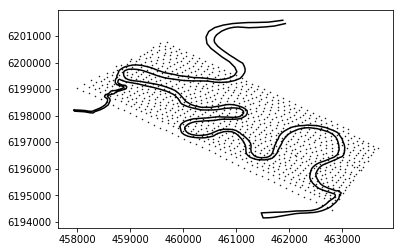

In [6]:
plt.plot(river_path[:,0], river_path[:,1], 'k-')
plt.plot(xy[:,0], xy[:,1], 'k.', ms=1)

# Seting up a 2D mesh and model

In [8]:
from scipy.constants import mu_0
frequency = np.array([382, 1822, 7970, 35920, 130100], dtype=float)
hz = get_vertical_discretization_frequency(frequency, sigma_background=1./50)
# survey parameters
rxOffset = 7.86  # tx-rx separation
bp = -mu_0/(4*np.pi*rxOffset**3)  # primary magnetic field

In [9]:
n_sounding = xy.shape[0]

In [10]:
b_height_resolve = resolve["src_elevation"].value[::nskip]
topo_resolve = resolve["ground_elevation"].value[::nskip]

In [11]:
x = xy[:,0]
y = xy[:,1]
z = topo_resolve + b_height_resolve
rx_locations = np.c_[x, y, z]
src_locations = np.c_[x, y, z]
topo = np.c_[x, y, topo_resolve].astype(float)

In [12]:
mapping = Maps.ExpMap(nP=int(n_sounding*hz.size))

In [14]:
survey = GlobalEM1DSurveyFD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    frequency = frequency,
    offset = np.ones_like(frequency) * 7.86,
    src_type = "VMD",
    rx_type = "Hz",
    field_type = 'secondary',
    topo = topo    
)
prob = GlobalEM1DProblemFD(
    [], sigmaMap=mapping, hz=hz, parallel=True, n_cpu=6,
    Solver=PardisoSolver
)
prob.pair(survey)

>> Use multiprocessing for parallelization
>> n_cpu: 6


In [15]:
m0 = np.ones(mapping.nP) * np.log(1./50)

In [16]:
%%time
pred = survey.dpred(m0)

CPU times: user 76.8 ms, sys: 34.3 ms, total: 111 ms
Wall time: 6.1 s


In [17]:
DOBS = np.empty((prob.n_sounding, 2, survey.n_frequency))
DPRED = pred.reshape((prob.n_sounding, 2, survey.n_frequency))
for i_freq in range(frequency_cp.size):
    DOBS[:,0,i_freq] = data_cpi[:, i_freq]
    DOBS[:,1,i_freq] = data_cpq[:, i_freq]    
DOBS *= bp * 1e-6

In [18]:
uniq_line = np.unique(line)

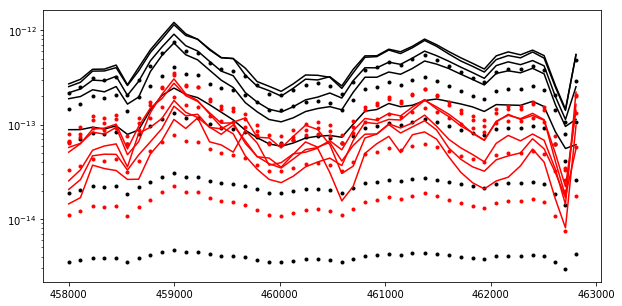

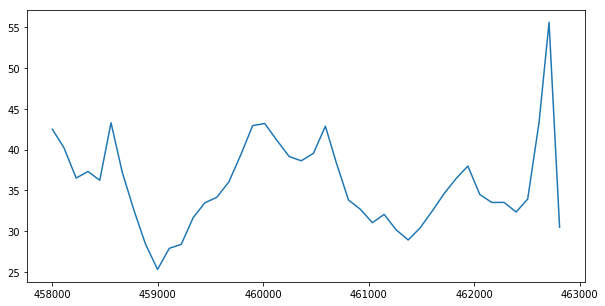

In [19]:

i_line = 0
ind_line = line == uniq_line[i_line]
figsize(10, 5)
for i_freq in range(survey.n_frequency):
    plt.semilogy(xy[ind_line,0], -DOBS[ind_line,0,i_freq], 'k')
    plt.semilogy(xy[ind_line,0], -DPRED[ind_line,0,i_freq], 'k.')    
for i_freq in range(survey.n_frequency):
    plt.semilogy(xy[ind_line,0], -DOBS[ind_line,1,i_freq], 'r')    
    plt.semilogy(xy[ind_line,0], -DPRED[ind_line,1,i_freq], 'r.')        
fig = plt.figure(figsize=(10, 5))
plt.plot(topo[ind_line,0], src_locations[ind_line,2]-topo[ind_line,2])

In [58]:
from SimPEG import (
    Regularization, Directives, Inversion, InvProblem, Optimization, DataMisfit, Utils
)

from simpegem1d import get_2d_mesh, LateralConstraint

mesh_reg = get_2d_mesh(n_sounding, hz)
# Now we can create the regularization using the 2D mesh
reg = LateralConstraint(mesh_reg, mapping=Maps.IdentityMap(nP=mesh_reg.nC))

In [59]:
tri = reg.get_grad_horizontal(xy, hz)

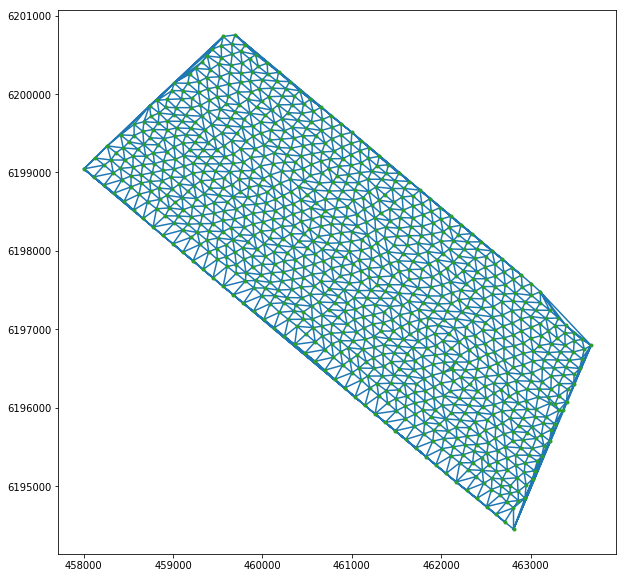

In [60]:
figsize(10, 10)
plt.triplot(xy[:,0], xy[:,1], tri.simplices)
plt.plot(xy[:,0], xy[:,1], '.')
plt.show()

In [61]:
DOBS.flatten().shape

(10220,)

In [62]:
dobs = DOBS.flatten()

In [63]:
%%time
std = 0.1
floor = abs(20 * bp * 1e-6)   # floor of 20ppm
uncert = std*abs(dobs)+floor
survey.dobs = dobs
m0 = np.ones(mesh_reg.nC) * np.log(1./100.)
dmisfit = DataMisfit.l2_DataMisfit(survey)
dmisfit.W = 1./uncert
regmap = Maps.IdentityMap(mesh_reg)
# mapping is required ... for IRLS
reg = LateralConstraint(
    mesh_reg, mapping=Maps.IdentityMap(nP=mesh_reg.nC),
    alpha_s=1.,
    alpha_x = 10.,
    alpha_y = 1.,        
)
tri = reg.get_grad_horizontal(xy, hz)
p = 0
qx, qz = 1., 1.
reg.norms = np.c_[p, qx, qz, 0.]
IRLS = Directives.Update_IRLS(maxIRLSiter=10, minGNiter=1)
opt = Optimization.InexactGaussNewton(maxIter = 20)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = Directives.TargetMisfit()
# inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest,target])
inv = Inversion.BaseInversion(invProb, directiveList=[IRLS,betaest])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***


/home/seogi/Documents/simpeg/SimPEG/Directives.py:843: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.96e-02  1.91e+05  0.00e+00  1.91e+05    1.47e+03      0              
   1  1.98e-02  4.21e+04  1.42e+05  4.49e+04    4.91e+02      0              
   2  9.91e-03  3.27e+04  2.97e+05  3.57e+04    5.06e+02      0   Skip BFGS  
   3  4.95e-03  1.40e+04  2.91e+05  1.54e+04    4.13e+02      0              
   4  2.48e-03  5.22e+03  2.73e+05  5.90e+03    1.69e+02      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
L[p qx qy qz]-norm : [[ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 ..., 
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]]
eps_p: 5.842177140087312 eps_q: 1.2890679138361893
eps_p: 5.842177140087312 eps_q: 1.2890679138361893
delta phim: 1.250

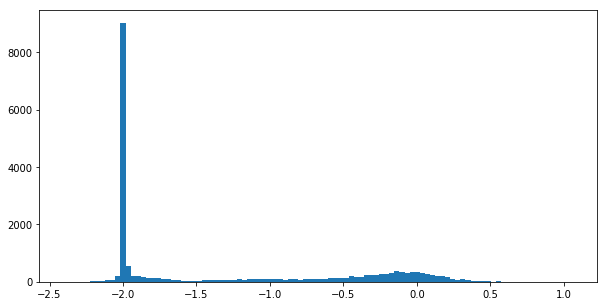

In [79]:
out = hist(np.log10(mapping*mopt), bins=100)

In [80]:
# out = hist(np.log10(mapping*invProb.l2model), bins=100)

In [81]:
m0

array([-4.60517019, -4.60517019, -4.60517019, ..., -4.60517019,
       -4.60517019, -4.60517019])

In [82]:
sigma = mapping * mopt

In [83]:
# sigma_l2 = mapping * invProb.l2model

In [84]:
PRED = invProb.dpred.reshape((prob.n_sounding, 2, survey.n_frequency))

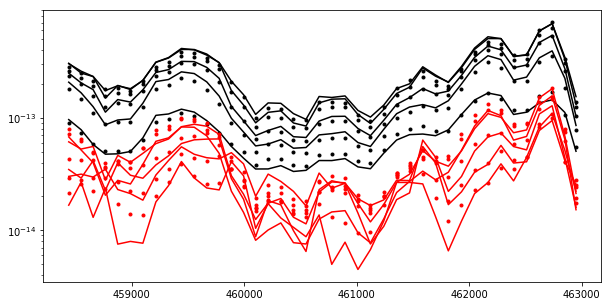

In [85]:
i_line = 4
ind_line = line == uniq_line[i_line]
figsize(10, 5)
for i_freq in range(survey.n_frequency):
    plt.semilogy(xy[ind_line,0], -DOBS[ind_line,0,i_freq], 'k')
    plt.semilogy(xy[ind_line,0], -PRED[ind_line,0,i_freq], 'k.')    
for i_freq in range(survey.n_frequency):
    plt.semilogy(xy[ind_line,0], -DOBS[ind_line,1,i_freq], 'r')    
    plt.semilogy(xy[ind_line,0], -PRED[ind_line,1,i_freq], 'r.')        

# Final 3D mesh output

In [86]:
from simpegem1d import set_mesh_1d
mesh_1d = set_mesh_1d(hz)
depth = -mesh_1d.gridN[:-1]
xyz = np.empty((hz.size, xy.shape[0], 3), order='F')
for i_xy in range(xy.shape[0]):
    z = - mesh_1d.vectorCCx + topo[i_xy, 2]
    x = np.ones_like(z) * xy[i_xy,0]
    y = np.ones_like(z) * xy[i_xy,1]
    xyz[:, i_xy, :] = np.c_[x, y, z]

In [87]:
Sigma = sigma.reshape((hz.size, n_sounding), order='F')
# Sigma_l2 = sigma_l2.reshape((hz.size, n_sounding), order='F')

In [88]:
xmin, xmax = xy[:,0].min(), xy[:,0].max()
ymin, ymax = xy[:,1].min(), xy[:,1].max()
zmin, zmax = topo[:,2].min() + depth.min(), topo[:,2].max()

In [89]:
zmin

-152.41917762615233

-5.26989552687


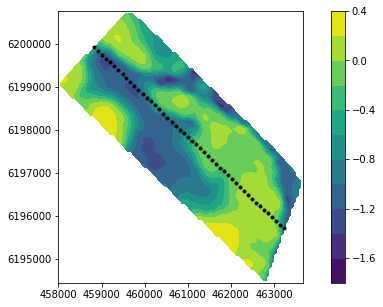

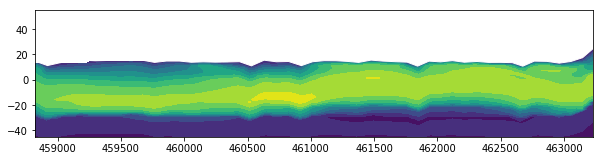

In [90]:
iz = 2
i_line = 11
ind_line = line == uniq_line[i_line]
xz = xyz[:, ind_line, :][:,:,[0,2]].reshape((int(hz.size*ind_line.sum()), 2), order='F')
print (depth[iz])
temp = sigma.reshape((mesh_reg.vnC), order='F')[iz,:]
fig = plt.figure(figsize=(8, 8))
out = Utils.plot2Ddata(xy, temp, scale='log', contourOpts={'cmap':'viridis'}, ncontour=10)
plt.plot(xy[ind_line,0], xy[ind_line,1], 'k.')
plt.colorbar(out[0])

fig = plt.figure()
sigma_xz = Utils.mkvc(Sigma[:,ind_line])
Utils.plot2Ddata(xz, sigma_xz, scale='log', dataloc=False)
plt.fill_between(topo[ind_line, 0], topo[ind_line, 2], topo[ind_line, 1]*0. + zmax, color='w')
plt.ylim(zmax-100, zmax)
plt.gca().set_aspect(10)

In [91]:
# iz = 4
# i_line = 10
# ind_line = line == uniq_line[i_line]
# xz = xyz[:, ind_line, :][:,:,[0,2]].reshape((int(hz.size*ind_line.sum()), 2), order='F')
# print (depth[iz])
# temp = sigma_l2.reshape((mesh_reg.vnC), order='F')[iz,:]
# fig = plt.figure(figsize=(8, 8))
# out = Utils.plot2Ddata(xy, temp, scale='log', contourOpts={'cmap':'viridis'}, ncontour=10)
# plt.plot(xy[ind_line,0], xy[ind_line,1], 'k.')
# plt.colorbar(out[0])

# fig = plt.figure()
# sigma_xz = Utils.mkvc(Sigma_l2[:,ind_line])
# Utils.plot2Ddata(xz, sigma_xz, scale='log', dataloc=False)
# plt.fill_between(topo[ind_line, 0], topo[ind_line, 2], topo[ind_line, 1]*0. + zmax, color='w')
# plt.ylim(zmax-100, zmax)
# plt.gca().set_aspect(10)

In [77]:
print (reg[0][0], reg[0][1](mopt))
print (reg[0][0], reg[1][1](mopt))
print (reg[0][0], reg[2][1](mopt))

1.0 84734.9137635
1.0 3955.72309054
1.0 24687.586763


In [78]:
# # Use Kdtree
# xyz = xyz.reshape((hz.size*xy.shape[0], 3), order='F')    
# from scipy.spatial import cKDTree
# tree = cKDTree(xyz)
# xmin, xmax = xyz[:,0].min(), xyz[:,0].max()
# ymin, ymax = xyz[:,1].min(), xyz[:,1].max()
# zmin, zmax = xyz[:,2].min(), xyz[:,2].max()
# print (xmin, xmax)
# print (ymin, ymax)
# print (zmin, zmax)
# dx = 40.
# dy = 40.
# dz = hz.min()
# nx = int(np.floor((xmax-xmin)/dx))
# ny = int(np.floor((ymax-ymin)/dy))
# nz = int(np.floor((zmax-zmin)/dz))
# x0 = [xmin-dx/2., ymin-dy/2., zmin-dz/2.]
# x = np.linspace(xmin-dx/2., xmax+dx/2., nx)
# y = np.linspace(ymin-dy/2., ymax+dy/2., ny)
# z = np.linspace(zmin-dz/2., zmax+dz/2., nz)
# mesh = Mesh.TensorMesh([np.diff(x),np.diff(y), np.diff(z)], x0=x0)
# d, inds = tree.query(mesh.gridCC, k = 10)
# w = 1.0 / (d+10.)**2
# sigma_out = np.sum(w * sigma[inds], axis=1) / np.sum(w, axis=1)